# WIP: Quantum chemistry with Qiskit Nature: finding the interatomic distance of a hydrogen molecule

Introduction

[refs: Sharkey and qiskit-nature documentation]
[look at qiskit nature documentation for explanations]

## MoleculeInfo
We start by describing the molecule that we want to look at, in our case a hydrogen molecule:

In [6]:
from qiskit_nature.second_q.formats import MoleculeInfo

distance = 0.735
molecule = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, distance)], charge=0, multiplicity=1)

* The symbols are for the two hydrogen atoms.
* We are going to vary the coordinates (in Angstrom) of the second hydrogen atom. We'll use 3 Angstrom as the initial point.
* The total charge of the hydrogen atom is 0.
* The multiplicity is 2 * S + 1, where S is the spin of the molecule due to unpaired electrons. The hydrogen molecule has no unpaired electrons, so the multiplicity is 1.

Next, we convert the molecule into an electronic structure problem through the PySCFDriver:

In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver.from_molecule(molecule)
es_problem = driver.run()

The PySCFDriver is a driver from the PySCF library designed for quantum chemistry calculations using second quantization. Second quantization is a method of describing molecular systems by transitioning from using individual electronic wave functions to representing the system in Fock space. In second quantization, instead of specifying the exact positions of electrons, we describe which eigenstates (or molecular orbitals) the electrons occupy. This framework simplifies the calculations, allowing us to systematically account for the possible interactions and configurations of multiple electrons within a molecule. 

The returned ElectronicStructureProblem leverages this Fock space representation to construct the Hamiltonian of the molecule, which is the operator describing the total energy of the system. It is called a fermionic operator, since electrons are fermions. We can also get information about the number of particles, the number of spatial orbitals, and the repulsion energy between the nuclei of the atoms. 

In [6]:
fermionic_op = es_problem.hamiltonian.second_q_op()
n_particles = es_problem.num_particles
n_spatial_orbitals = es_problem.num_spatial_orbitals
nuclear_repulsion_energy = es_problem.nuclear_repulsion_energy

## ParityMapper
To do quantum chemistry calculations using quantum computing, fermionice operators (i.e. operators on electrons) need to be converted to operators on qubits. This is done with a mapper, e.g. the ParityMapper. The ParityMapper encodes the occupation of molecular orbitals into qubits in such a way that preserves information about the parity (even or odd count of occupied states) in parts of the system. By keeping track of parity, this mapping can reduce the number of qubits required for certain molecules, as some qubits become redundant and can be removed, leading to more efficient quantum circuits. Other mappers are JordanWignerMapper, BravyiKitaevMapper, and BravyiKitaevSuperFastMapper, each providing different trade-offs in terms of qubit efficiency and circuit complexity. 

In [7]:
from qiskit_nature.second_q.mappers import ParityMapper

mapper = ParityMapper(num_particles=(1, 1))
qubit_op = mapper.map(fermionic_op)

## todo: VQEUCCFactory
We are going to calculate the interatomic distance of hydrogen using the Variational Quantum Eigensolver (VQE) algorithm. VQE works in a loop, where each iteration has the following steps:
 * A quantum circuit (a sequence of qubit operations) is described by a set of parameters
 * The qubit values are measured after executing the quantum circuit.
 * Based on the qubit values, new parameters for the quantum circuit are chosen.

In our case the qubit values represent the energy of the hydrogen molecule. The goal of the loop is to find the parameters of the quantum circuit that give the lowest energy (ground state energy). The parameters of the quantum circuit model the state of the electrons of the hydrogen molecule. [how does it determine this?]


In [8]:
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

initial_state = HartreeFock(n_spatial_orbitals, n_particles, mapper)
ansatz = UCCSD(n_spatial_orbitals, n_particles, mapper, initial_state=initial_state)

The VQEUCCFactory makes a VQE instance.
* an Estimator instance is used to estimate the eigenvalues [how exactly? why?]
* the UCCSD constructs a multi-electron wave function as the ansatz, with the sum of single (S) and double (D) excitations [how exactly? what is UCC?]
* optimization in the loop is done by the Sequential Least SQuares Programming optimizer






VQEUCCFactory and Estimator, UCCSD, SLSQP
PySCFDriver
ActiveSpaceTransformer
GroundStateEigenSolver

In [17]:
from qiskit.primitives import Estimator

estimator = Estimator()  # todo: move to V2 Estimator once https://github.com/qiskit-community/qiskit-algorithms/issues/136 is fixed

/tmp/ipykernel_9/2561769255.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator() #BackendEstimatorV2(backend=backend)


In [18]:

from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=1)

In [19]:
from qiskit_algorithms import VQE

algo = VQE(estimator, ansatz, optimizer)
result = algo.compute_minimum_eigenvalue(qubit_op)

#00 at 0.25 Angstrom -> energy: -0.312
#01 at 0.35 Angstrom -> energy: -0.789
#02 at 0.45 Angstrom -> energy: -0.998
#03 at 0.55 Angstrom -> energy: -1.093
#04 at 0.65 Angstrom -> energy: -1.130
#05 at 0.75 Angstrom -> energy: -1.137
#06 at 0.85 Angstrom -> energy: -1.128
#07 at 0.95 Angstrom -> energy: -1.111
#08 at 1.05 Angstrom -> energy: -1.090
#09 at 1.15 Angstrom -> energy: -1.068
#10 at 1.25 Angstrom -> energy: -1.046
#11 at 1.35 Angstrom -> energy: -1.025
#12 at 1.45 Angstrom -> energy: -1.006
#13 at 1.55 Angstrom -> energy: -0.990
#14 at 1.65 Angstrom -> energy: -0.977
#15 at 1.75 Angstrom -> energy: -0.966
#16 at 1.85 Angstrom -> energy: -0.958
#17 at 1.95 Angstrom -> energy: -0.951


Text(0, 0.5, 'Ground state energy [Hartree]')

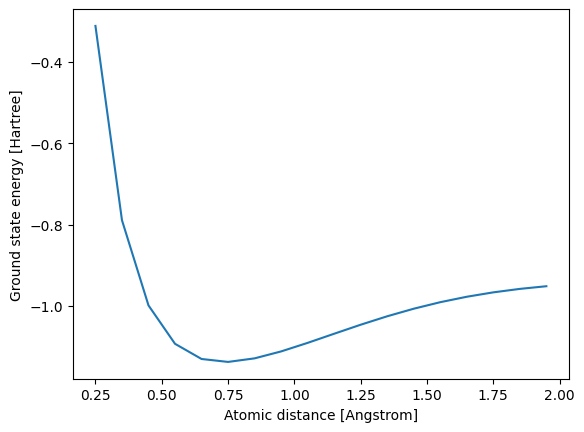

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from quantum_algorithms.vqe.energy_calculation import GroundStateEnergyCalculation

distances = np.arange(0.25, 2.0, 0.1)
calc = GroundStateEnergyCalculation(molecule, n_max_iterations=1000)
energies = []
for i, d in enumerate(distances):
    calc.update_last_atoms_coords((0, 0, d))
    energy = calc.run()
    energies.append(energy)
    # todo: replace with tqdm?
    print(f"#{i:0>2} at {d:.2f} Angstrom -> energy: {energy:.3f}")
    
fig, ax = plt.subplots()
ax.plot(distances, energies)
ax.set_xlabel("Atomic distance [Angstrom]")
ax.set_ylabel("Ground state energy [Hartree]")


In [18]:
from quantum_algorithms.vqe.distance_finder import DistanceFinder

# todo: print formatted

distance_finder = DistanceFinder(iteration_callback=print, atoms=("H", "H"))
distance = distance_finder.run()
print(f"=== The distance between the two H atoms of the hydrogen molecule is calculated to be {distance:.3f} Angstrom ===")

IterationInfo(coords=(0.0, 0.0, 3.0), ground_state_energy=np.float64(-0.9332850847350438))
IterationInfo(coords=(1.0, 0.0, 3.0), ground_state_energy=np.float64(-0.9332415915876315))
IterationInfo(coords=(0.0, 1.0, 3.0), ground_state_energy=np.float64(-0.9332539940130959))
IterationInfo(coords=(0.0, 0.0, 4.0), ground_state_energy=np.float64(-0.9331691336890521))
IterationInfo(coords=(-0.3406339880867496, -0.24349943013338016, 2.0918829845857774), ground_state_energy=np.float64(-0.9432128295359181))
IterationInfo(coords=(-0.34462136429923995, -0.24634977352078613, 1.0918949964711633), ground_state_energy=np.float64(-1.063168877721067))
IterationInfo(coords=(0.5798888085448716, -0.2464476069523049, 0.7107376395483689), ground_state_energy=np.float64(-1.1113748494624063))
IterationInfo(coords=(0.5851686226511074, 0.7121509816270251, 0.4260257333401459), ground_state_energy=np.float64(-1.0978688462394972))
IterationInfo(coords=(0.6009653220859251, -0.629441220423437, -0.21277287615639495), 